In [1]:
# Purpose: This notebook aims to use Pokemon base stats to create a supervised model to identify 
# at least 1 type of Pokemon.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, average_precision_score, classification_report, confusion_matrix, plot_precision_recall_curve, precision_recall_curve, roc_curve
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
%matplotlib inline

In [2]:
# First we take our initial look at the dataset

pkmn_type = pd.read_csv('../../data/Pokemon.csv')
pkmn_type.info()
pkmn_type.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

abilities  against_bug  against_dark  against_dragon  \
0  ['Overgrow', 'Chlorophyll']          1.0           1.0             1.0   
1  ['Overgrow', 'Chlorophyll']          1.0           1.0             1.0   
2  ['Overgrow', 'Chlorophyll']          1.0           1.0             1.0   
3     ['Blaze', 'Solar Power']          0.5           1.0             1.0   
4     ['Blaze', 'Solar Power']          0.5           1.0             1.0   

   against_electric  against_fairy  against_fight  against_fire  \
0               0.5            0.5            0.5           2.0   
1               0.5            0.5            0.5           2.0   
2               0.5            0.5            0.5           2.0   
3               1.0            0.5            1.0           0.5   
4               1.0            0.5            1.0           0.5   

   against_flying  against_ghost  ...  percentage_male  pokedex_number  \
0             2.0            1.0  ...             88.1               1   
1             2.0            1.0  ...             88.1               2   
2             2.0            1.0  ...             88.1               3   
3             1.0            1.0  ...             88.1               4   
4             1.0            1.0  ...             88.1               5   

   sp_attack  sp_defense  speed  type1   type2  weight_kg  generation  \
0         65          65     45  grass  poison        6.9           1   
1         80          80     60  grass  poison       13.0           1   
2        122         120     80  grass  poison      100.0           1   
3         60          50     65   fire     NaN        8.5           1   
4         80          65     80   fire     NaN       19.0           1   

   is_legendary  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 41 columns]

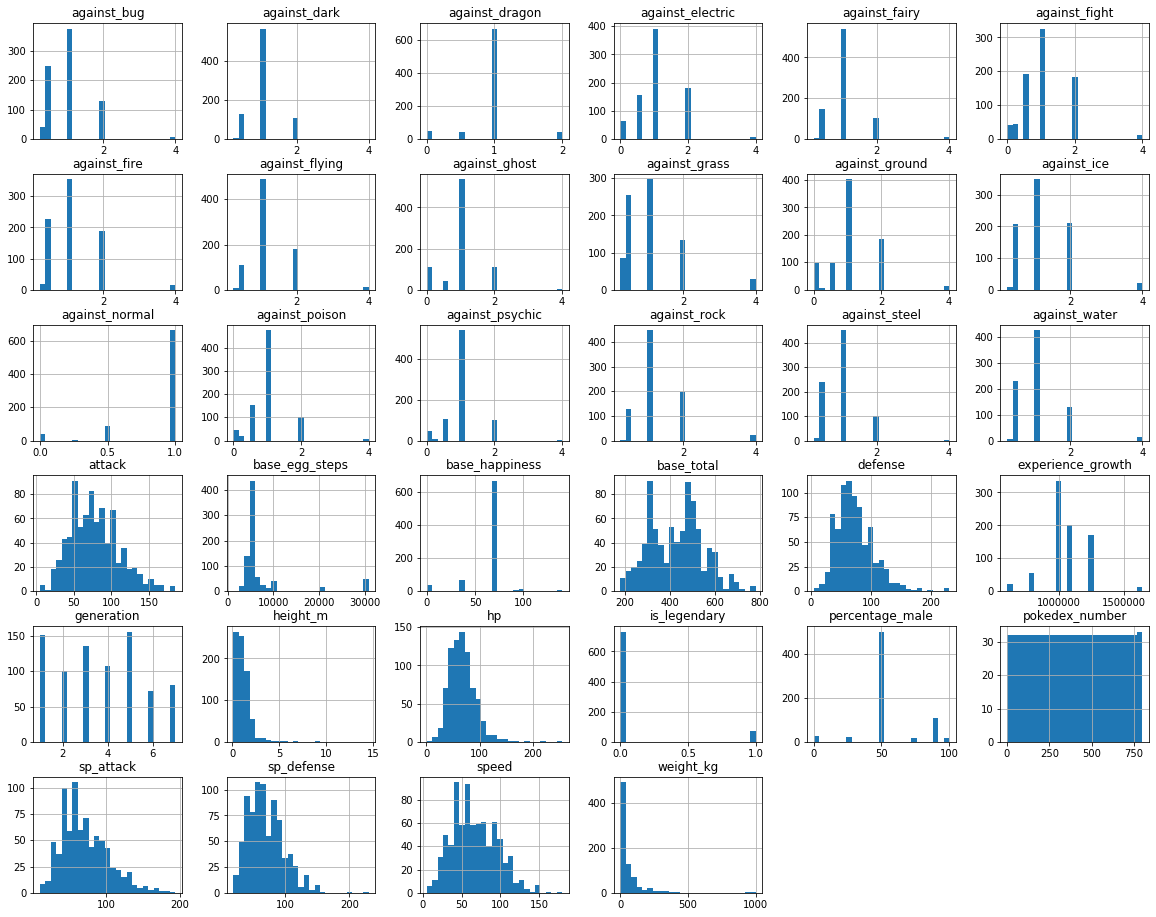

In [3]:
# We separate out numerical values and identify that base stats are generally normally distributed.

nums = pkmn_type.select_dtypes(include=['float64','int64'])
clmns = list(nums.columns)
nums.hist(bins=25, figsize=(20,16))
plt.show()

In [4]:
# For categorical variables, we're only concerned with the breakdown of the type1/type2 of each Pokemon.
# We notice that there may be a class imbalance issue when we create our model due to the discrepancy in the size
# of each Pokemon type relative to the total number of Pokemon.

categoricals = pkmn_type.select_dtypes(include='object')
clmns = list(categoricals.columns)
print((categoricals.type1.value_counts(normalize=False, dropna=True) + categoricals.type2.value_counts(normalize=False, dropna=True)).sort_values(ascending=False))
print((categoricals.type1.value_counts(normalize=False, dropna=True) + categoricals.type2.value_counts(normalize=False, dropna=True)).sort_values(ascending=False).sum())

water       131
normal      109
flying       98
grass        98
psychic      82
bug          77
ground       66
poison       66
fire         65
rock         59
fighting     53
dark         50
electric     48
fairy        47
steel        46
dragon       44
ghost        41
ice          38
dtype: int64
1218


In [5]:
# Now we prepare a dataset for our model. We convert each 'type' column to explicit individual Pokemon type columns.

pkmn_type_to_edit = pkmn_type.copy()
pkmn_type_to_edit = pkmn_type_to_edit[pkmn_type_to_edit['is_legendary']==0] 
inputs = ['attack','base_total','defense','hp','sp_attack','sp_defense','speed']
output_types = pkmn_type_to_edit.type1.unique()
all_features = inputs.copy()
for curr_type in output_types:
    pkmn_type_to_edit['is_' + curr_type] = ((pkmn_type_to_edit['type1'] == curr_type) | (pkmn_type_to_edit['type2'] == curr_type)).astype(float)
    all_features.append('is_' + curr_type)
working_pkmn_df = pkmn_type_to_edit[all_features]
working_pkmn_df.head()

attack  base_total  defense  hp  sp_attack  sp_defense  speed  is_grass  \
0      49         318       49  45         65          65     45       1.0   
1      62         405       63  60         80          80     60       1.0   
2     100         625      123  80        122         120     80       1.0   
3      52         309       43  39         60          50     65       0.0   
4      64         405       58  58         80          65     80       0.0   

   is_fire  is_water  ...  is_fairy  is_fighting  is_psychic  is_rock  \
0      0.0       0.0  ...       0.0          0.0         0.0      0.0   
1      0.0       0.0  ...       0.0          0.0         0.0      0.0   
2      0.0       0.0  ...       0.0          0.0         0.0      0.0   
3      1.0       0.0  ...       0.0          0.0         0.0      0.0   
4      1.0       0.0  ...       0.0          0.0         0.0      0.0   

   is_ghost  is_ice  is_dragon  is_dark  is_steel  is_flying  
0       0.0     0.0        0.0      0.0       0.0        0.0  
1       0.0     0.0        0.0      0.0       0.0        0.0  
2       0.0     0.0        0.0      0.0       0.0        0.0  
3       0.0     0.0        0.0      0.0       0.0        0.0  
4       0.0     0.0        0.0      0.0       0.0        0.0  

[5 rows x 25 columns]

In [6]:
# Check if dataset has any null values to address.

working_pkmn_df.isnull().sum()

attack         0
base_total     0
defense        0
hp             0
sp_attack      0
sp_defense     0
speed          0
is_grass       0
is_fire        0
is_water       0
is_bug         0
is_normal      0
is_poison      0
is_electric    0
is_ground      0
is_fairy       0
is_fighting    0
is_psychic     0
is_rock        0
is_ghost       0
is_ice         0
is_dragon      0
is_dark        0
is_steel       0
is_flying      0
dtype: int64

Text(0.5, 1, '0.3 Correlation Threshold')

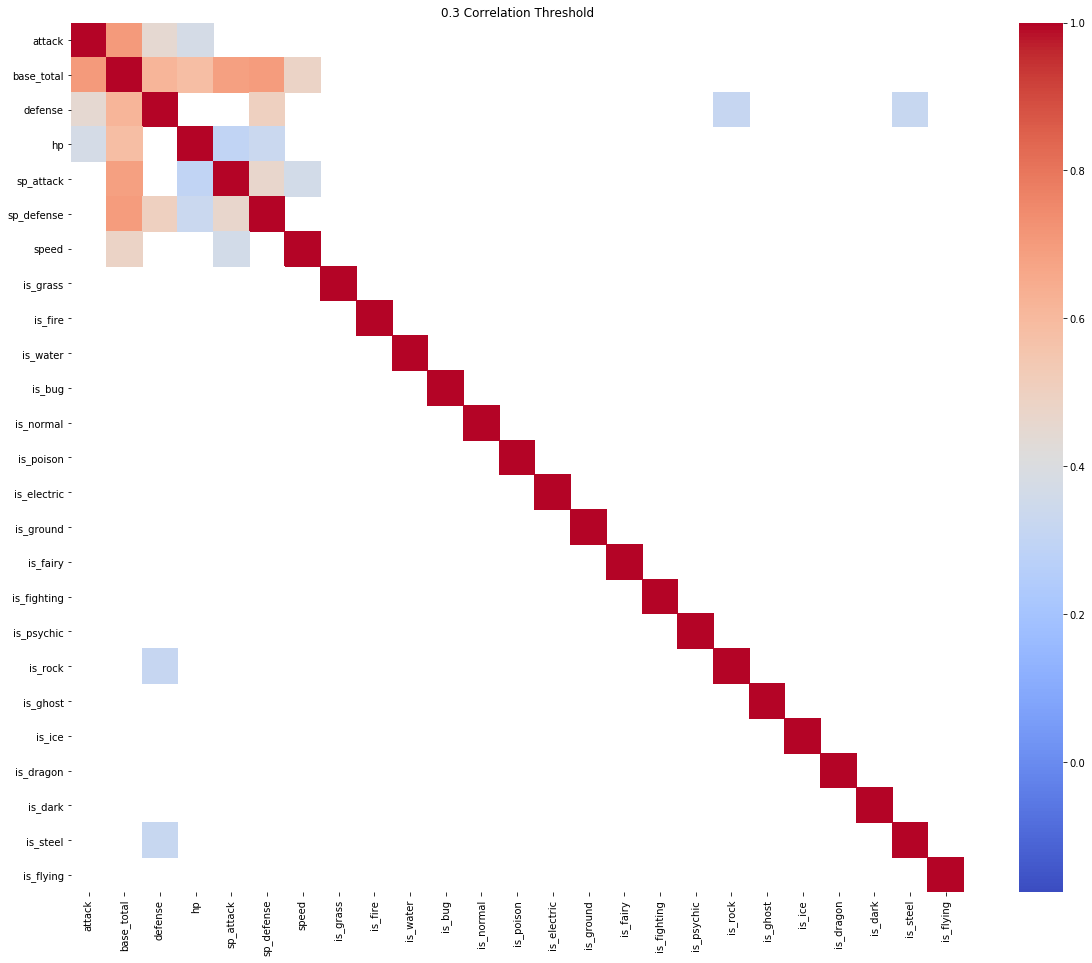

In [7]:
# Check correlations within the dataset. (<.2: very weak, .2<=x<.4: weak, .4<=x<.6: moderate, .6<=x<.8: strong)
# We find that base_total has a moderate+ correlation with each base stat, so we consider it for removal
# to simplify our model.
# We also find that 'is_steel' and 'is_rock' have similar correlations among most stats.
# Let's decide to look for Rock types.

corr = working_pkmn_df.corr()
# fig, ax = plt.subplots(figsize=(20,16))
# sns.heatmap(corr,
#         cmap='coolwarm',
#         mask=corr<.3,
#         xticklabels=corr.columns,
#         yticklabels=corr.columns,
#         ax=ax)

fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(corr,
        cmap='coolwarm',
        mask=corr<.3,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        ax=ax)
ax.set_title('0.3 Correlation Threshold')

# fig, ax = plt.subplots(figsize=(20,16))
# sns.heatmap(corr,
#         cmap='coolwarm',
#         mask=corr<.4,
#         xticklabels=corr.columns,
#         yticklabels=corr.columns,
#         ax=ax)
# ax.set_title('0.4 Correlation Threshold')

In [8]:
# Scale data to help our model process the data.
# Base stats are somewhat normally distributed, so we consider Standard Scaler.

target_name = 'is_rock'
inputs = ['attack','defense','hp','sp_attack','sp_defense','speed']
X = working_pkmn_df[inputs]
y = working_pkmn_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,stratify=y)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [9]:
# This is a binary classification problem. We are trying to predict if a Pokemon is either a rock type or not.
# Try basic Logistic Regression; metrics we value are Recall and F1.
# We want to predict as many rock types as rock as possible without disregarding precision.

scoring=['f1','recall']
def model_LR(target_name, df, inputs, scoring, sample, threshold=0.0):
    X = df[inputs]
    y = df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,stratify=y)
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    # Create synthetic samples
    if sample:
        over = SMOTE(random_state=22, sampling_strategy='auto')
        steps = [('o', over)]
        pipeline = Pipeline(steps=steps)
        X_train, y_train = pipeline.fit_resample(X_train, y_train)
    
    # Run LR; cross validate
    LR = LogisticRegression(random_state=22)
    scores = cross_validate(LR, X_train, y_train, cv=5, scoring=scoring)
    print(scores)

    # Get confusion matrix
    LR_fit = LR.fit(X_train, y_train)
    y_test_pred = LR_fit.predict(X_test)
    if threshold != 0.0:
        y_score = LR_fit.decision_function(X_test)
        average_precision = average_precision_score(y_test, y_score)
        disp = plot_precision_recall_curve(LR_fit, X_test, y_test)
        disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        predict_probabilities = LR_fit.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, predict_probabilities[:,1])
        roc_auc = auc(fpr, tpr)
        disp.ax_.text(.75, .9, 'AUC = %0.2f' % roc_auc)
        predict_mine = np.where(predict_probabilities[:,1] > threshold, 1, 0)
        print(classification_report(y_test, predict_mine)) 
        print(confusion_matrix(y_test, predict_mine))
    else:
        print(classification_report(y_test, y_test_pred)) 
        cm = confusion_matrix(y_test, y_test_pred)
        print(cm)
    
    return LR_fit

In [10]:
# From the confusion matrix below, the model does not seem to do well in identifying True rock type Pokemon.
# One issue we noticed previously was the class imbalance in the dataset, so let's address that.

LR_fit = model_LR(target_name, working_pkmn_df, inputs, scoring, False, 0.0)

{'fit_time': array([0.0205102 , 0.00597787, 0.00662303, 0.00608206, 0.00521827]), 'score_time': array([0.00369096, 0.00587916, 0.00299191, 0.00246477, 0.00337982]), 'test_f1': array([0.18181818, 0.        , 0.22222222, 0.2       , 0.        ]), 'test_recall': array([0.125     , 0.        , 0.14285714, 0.125     , 0.        ])}
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       203
         1.0       0.50      0.12      0.19        17

    accuracy                           0.92       220
   macro avg       0.72      0.55      0.57       220
weighted avg       0.90      0.92      0.90       220

[[201   2]
 [ 15   2]]


In [11]:
# Create synthetic samples
over = SMOTE(random_state=22, sampling_strategy='auto')
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [12]:
# Addressing class imbalance helps our recall, but tanks our precision

LR_fit = model_LR(target_name, working_pkmn_df, inputs, scoring, True, 0.0)

{'fit_time': array([0.01130795, 0.01597118, 0.00737405, 0.0087111 , 0.00627303]), 'score_time': array([0.0097003 , 0.00404596, 0.00292683, 0.00266075, 0.00494695]), 'test_f1': array([0.71351351, 0.74193548, 0.72928177, 0.83769634, 0.79144385]), 'test_recall': array([0.69473684, 0.73404255, 0.70212766, 0.84210526, 0.77894737])}
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87       203
         1.0       0.21      0.65      0.31        17

    accuracy                           0.78       220
   macro avg       0.59      0.72      0.59       220
weighted avg       0.91      0.78      0.83       220

[[161  42]
 [  6  11]]


{'fit_time': array([0.01018071, 0.0072    , 0.0068717 , 0.00666785, 0.00952601]), 'score_time': array([0.00265217, 0.00364184, 0.00347114, 0.0033679 , 0.00267982]), 'test_f1': array([0.71351351, 0.74193548, 0.72928177, 0.83769634, 0.79144385]), 'test_recall': array([0.69473684, 0.73404255, 0.70212766, 0.84210526, 0.77894737])}
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       203
         1.0       0.50      0.47      0.48        17

    accuracy                           0.92       220
   macro avg       0.73      0.72      0.72       220
weighted avg       0.92      0.92      0.92       220

[[195   8]
 [  9   8]]


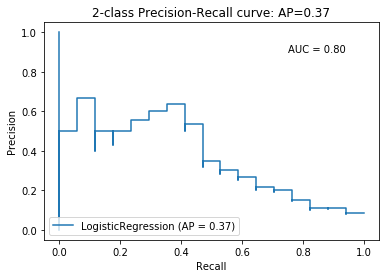

In [13]:
# We change our model's threshold to try to maximize recall without
# completely disregarding our f1-score

LR_fit = model_LR(target_name, working_pkmn_df, inputs, scoring, True, 0.8)

In [14]:
def model_SVC(target_name, df, inputs, scoring, sample, threshold=0.0):
    X = df[inputs]
    y = df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,stratify=y)
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    # Create synthetic samples
    if sample:
        over = SMOTE(random_state=22, sampling_strategy='auto')
        steps = [('o', over)]
        pipeline = Pipeline(steps=steps)
        X_train, y_train = pipeline.fit_resample(X_train, y_train)
    
    # Run SVC; cross validate
    svc = SVC(kernel='linear', probability=True, random_state=22)
    scores = cross_validate(svc, X_train, y_train, cv=5, scoring=scoring)
    print(scores)

    # Get confusion matrix
    SVC_fit = svc.fit(X_train, y_train)
    y_test_pred = SVC_fit.predict(X_test)
    if threshold != 0.0:
        y_score = SVC_fit.decision_function(X_test)
        average_precision = average_precision_score(y_test, y_score)
        disp = plot_precision_recall_curve(SVC_fit, X_test, y_test)
        disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        predict_probabilities = SVC_fit.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, predict_probabilities[:,1])
        roc_auc = auc(fpr, tpr)
        disp.ax_.text(.75, .95, 'AUC = %0.2f' % roc_auc)
        predict_mine = np.where(predict_probabilities[:,1] > threshold, 1, 0)
        print(classification_report(y_test, predict_mine)) 
        print(confusion_matrix(y_test, predict_mine))
    else:
        print(classification_report(y_test, y_test_pred)) 
        cm = confusion_matrix(y_test, y_test_pred)
        print(cm)
    return SVC_fit

{'fit_time': array([0.06880903, 0.05228925, 0.05186367, 0.05314398, 0.05523992]), 'score_time': array([0.00585389, 0.00353885, 0.00351715, 0.003793  , 0.00338984]), 'test_f1': array([0.7032967 , 0.71910112, 0.69714286, 0.83769634, 0.80434783]), 'test_recall': array([0.67368421, 0.68085106, 0.64893617, 0.84210526, 0.77894737])}
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       203
         1.0       0.38      0.65      0.48        17

    accuracy                           0.89       220
   macro avg       0.67      0.78      0.71       220
weighted avg       0.92      0.89      0.90       220

[[185  18]
 [  6  11]]


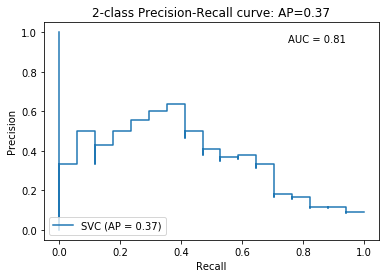

In [16]:
# Try more models: SVC
# Maximizing recall, we get results that are slightly better than the LR model.

SVC_fit = model_SVC(target_name, working_pkmn_df, inputs, scoring, True, 0.62)

In [17]:
def model_RFC(target_name, df, inputs, scoring, sample, threshold=0.0):
    X = df[inputs]
    y = df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,stratify=y)
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    # Create synthetic samples
    if sample:
        over = SMOTE(random_state=22, sampling_strategy='auto')
        steps = [('o', over)]
        pipeline = Pipeline(steps=steps)
        X_train, y_train = pipeline.fit_resample(X_train, y_train)
    
    # Run RFC; cross validate
    RFC = RandomForestClassifier(random_state=22)
    scores = cross_validate(RFC, X_train, y_train, cv=5, scoring=scoring)
    print(scores)

    # Get confusion matrix
    RFC_fit = RFC.fit(X_train, y_train)
    y_test_pred = RFC_fit.predict(X_test)
    if threshold != 0.0:
        predict_probabilities = RFC_fit.predict_proba(X_test)
        average_precision = average_precision_score(y_test, predict_probabilities[:,1])
        disp = plot_precision_recall_curve(RFC_fit, X_test, y_test)
        disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        fpr, tpr, thresholds = roc_curve(y_test, predict_probabilities[:,1])
        roc_auc = auc(fpr, tpr)
        disp.ax_.text(.75, .95, 'AUC = %0.2f' % roc_auc)
        predict_mine = np.where(predict_probabilities[:,1] > threshold, 1, 0)
        print(classification_report(y_test, predict_mine)) 
        print(confusion_matrix(y_test, predict_mine))
    else:
        print(classification_report(y_test, y_test_pred)) 
        cm = confusion_matrix(y_test, y_test_pred)
        print(cm)
    return RFC_fit

{'fit_time': array([0.25857425, 0.23967481, 0.23550797, 0.23798132, 0.24485207]), 'score_time': array([0.02624083, 0.01493192, 0.01587129, 0.01893592, 0.01641178]), 'test_f1': array([0.94736842, 0.89      , 0.93548387, 0.95      , 0.94358974]), 'test_recall': array([0.94736842, 0.94680851, 0.92553191, 1.        , 0.96842105])}
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       203
         1.0       0.33      0.41      0.37        17

    accuracy                           0.89       220
   macro avg       0.64      0.67      0.65       220
weighted avg       0.90      0.89      0.90       220

[[189  14]
 [ 10   7]]


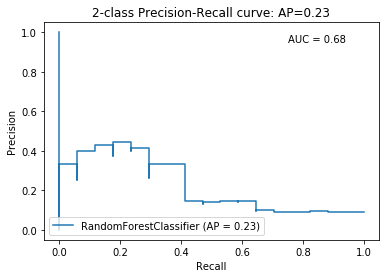

In [18]:
# Try more models: RFC
# We find that RFC just doesn't perform as well as the other 2 models.

RFC_fit = model_RFC(target_name, working_pkmn_df, inputs, scoring, True, .55)

In [19]:
def feat_elim(title, model, X_train, y_train, curr_df, inputs):
    rfecv = RFECV(estimator=model, step=1, cv=5, n_jobs=-1, scoring='f1')
    rfecv.fit(X_train, y_train)
    print('Optimal number of features: {}'.format(rfecv.n_features_))
    df = curr_df[inputs]
    new_features = list(df.columns[rfecv.support_])
    coefficients = rfecv.estimator.coef_.flatten()
    while len(coefficients) > len(new_features):
        coefficients = np.delete(coefficients, np.absolute(coefficients).argmin())
    coef_importances = pd.Series(coefficients, index=new_features).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(8,5))
    coef_importances.plot(kind='barh', ax=ax)
    ax.set_title(title)

Optimal number of features: 4


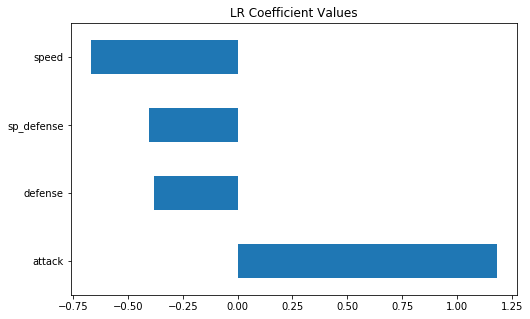

In [20]:
# At this point, we decide to drop Random Forest as a model option.
# We perform recursive feature elimination to see which features provide
# the most variance/importance for each remaining model.
# LR

feat_elim('LR Coefficient Values', LR_fit, X_train, y_train, working_pkmn_df, inputs)

Optimal number of features: 6


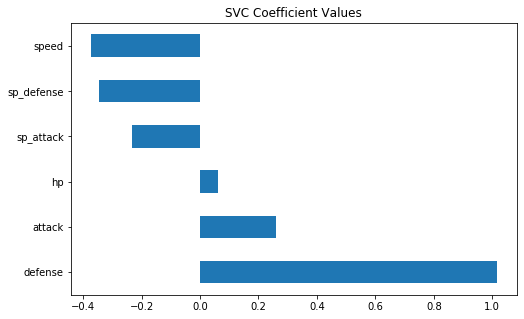

In [21]:
# SVC

feat_elim('SVC Coefficient Values', SVC_fit, X_train, y_train, working_pkmn_df, inputs)

{'fit_time': array([0.00543308, 0.00652909, 0.00711489, 0.00517511, 0.00502181]), 'score_time': array([0.00422907, 0.00303102, 0.0037818 , 0.00388002, 0.00258422]), 'test_f1': array([0.71351351, 0.72527473, 0.71910112, 0.81914894, 0.80662983]), 'test_recall': array([0.69473684, 0.70212766, 0.68085106, 0.81052632, 0.76842105])}
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92       203
         1.0       0.32      0.71      0.44        17

    accuracy                           0.86       220
   macro avg       0.64      0.79      0.68       220
weighted avg       0.92      0.86      0.88       220

[[177  26]
 [  5  12]]


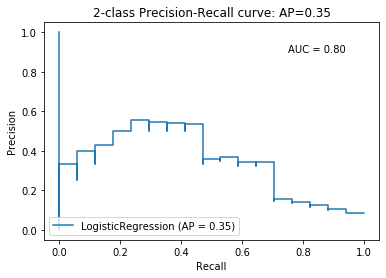

In [22]:
# With feature elimination, we can reach a higher recall percentage
# while sacrificing some precision, meaning the model is classifying more Pokemon as Rock than there 
# are actual Rock types.

new_LR_inputs = ['attack','defense','sp_defense','speed']
LR_fit = model_LR(target_name, working_pkmn_df, new_LR_inputs, scoring, True, .56)

{'fit_time': array([0.0590148 , 0.04786515, 0.04851604, 0.04763985, 0.05008197]), 'score_time': array([0.00343013, 0.00375819, 0.00516105, 0.00361514, 0.00343823]), 'test_f1': array([0.69945355, 0.7311828 , 0.70857143, 0.80874317, 0.80446927]), 'test_recall': array([0.67368421, 0.72340426, 0.65957447, 0.77894737, 0.75789474])}
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       203
         1.0       0.36      0.71      0.48        17

    accuracy                           0.88       220
   macro avg       0.67      0.80      0.71       220
weighted avg       0.93      0.88      0.90       220

[[182  21]
 [  5  12]]


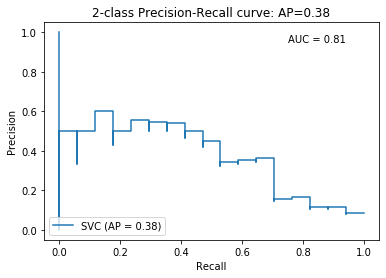

In [23]:
# Since we observe the variance contribution of hp is low, we manually remove the feature to try out
# a different feature combination for the model.
# We find that SVC's recall improved more than its precision suffered while maintaining a similar f1-score pre-feature
# elimination and additionally performs slightly better than LR.

new_SVC_inputs = ['attack','defense','sp_attack','sp_defense','speed']
SVC_fit = model_SVC(target_name, working_pkmn_df, new_SVC_inputs, scoring, True, .59)

In [24]:
# Let's look closer at why our model performed the way it did.
# We look at what was mislabeled in SVC.

X = working_pkmn_df[new_SVC_inputs]
y = working_pkmn_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,stratify=y)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
y_test_pred = SVC_fit.predict(X_test)

backtrack_inputs = ['name','attack','defense','hp','sp_attack','sp_defense','speed']
output_types = pkmn_type_to_edit.type1.unique()
all_features = backtrack_inputs.copy()

for curr_type in output_types:
    pkmn_type_to_edit['is_' + curr_type] = ((pkmn_type_to_edit['type1'] == curr_type) | (pkmn_type_to_edit['type2'] == curr_type)).astype(float)
    all_features.append('is_' + curr_type)

backtrack_df = pkmn_type_to_edit[all_features]
target_name = 'is_rock'
X = backtrack_df[backtrack_inputs]
y = backtrack_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,stratify=y)
predictions = X_test
predictions['label'] = y_test
predictions['pred_label'] = y_test_pred
pd.set_option('display.max_rows', None)
predictions

/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


name  attack  defense   hp  sp_attack  sp_defense  speed  label  \
256    Blaziken     160       80   80        130          80    100    0.0   
536  Seismitoad      95       75  105         85          75     74    0.0   
419     Cherubi      35       45   45         62          53     35    0.0   
357    Chimecho      50       80   75         95          90     65    0.0   
204  Forretress      90      140   75         60          60     40    0.0   
781    Jangmo-o      55       65   45         45          45     45    0.0   
765   Passimian     120       90  100         40          60     80    0.0   
161      Furret      76       64   85         45          55     90    0.0   
44    Vileplume      80       85   75        110          90     50    0.0   
319     Wailmer      70       35  130         70          35     60    0.0   
475   Probopass      55      145   60         75         150     40    1.0   
365    Clamperl      64       85   35         74          55     32    0.0   
95      Drowzee      48       45   60         43          90     42    0.0   
685       Inkay      54       53   53         37          46     45    0.0   
78     Slowpoke      65       65   90         40          40     15    0.0   
517    Musharna      55       85  116        107          95     29    0.0   
437      Bonsly      80       95   50         10          45     10    1.0   
469     Leafeon     110      130   65         60          65     95    0.0   
584    Deerling      60       50   60         40          50     75    0.0   
90     Cloyster      95      180   50         85          45     70    0.0   
255   Combusken      85       60   60         85          60     55    0.0   
201   Wobbuffet      33       58  190         33          58     33    0.0   
398      Bidoof      45       40   59         35          40     31    0.0   
10      Metapod      20       55   50         25          25     30    0.0   
531     Timburr      80       55   75         25          35     35    0.0   
77     Rapidash     100       70   65         80          80    105    0.0   
730     Pikipek      75       30   35         30          30     65    0.0   
585    Sawsbuck     100       70   80         60          70     95    0.0   
463   Rhyperior     140      130  115         55          55     40    1.0   
748     Mudbray     100       70   70         45          55     45    0.0   
225     Mantine      40       70   85         80         140     70    0.0   
608  Chandelure      55       90   60        145          90     80    0.0   
281   Gardevoir      85       65   68        165         135    100    0.0   
278    Pelipper      50      100   60         95          70     65    0.0   
74     Graveler      95      115   55         45          45     35    1.0   
516       Munna      25       45   76         67          55     24    0.0   
75        Golem     120      130   80         55          65     45    1.0   
570     Zoroark     105       60   60        120          60    105    0.0   
312     Volbeat      73       75   65         47          85     85    0.0   
773      Minior     100       60   60        100          60    120    1.0   
285     Breloom     130       80   60         60          60     70    0.0   
692   Clawitzer      73       88   71        120          89     59    0.0   
578   Reuniclus      65       75  110        125          85     30    0.0   
55       Mankey      80       35   40         35          45     70    0.0   
616    Accelgor      70       40   80        100          60    145    0.0   
687     Binacle      52       67   42         39          56     50    1.0   
488      Phione      80       80   80         80          80     80    0.0   
521     Blitzle      60       32   45         50          32     76    0.0   
370       Bagon      75       60   45         40          30     50    0.0   
196     Umbreon      65      110   95         60         130     65    0.0   
680   Aegislash     150       50 

In [25]:
# Looking at our false negatives below, these rock-types have uncharacteristically
# low defense and average to high attack and speeds.

SVC_FNs = predictions[(predictions['label'] == 1.0) & (predictions['label'] != predictions['pred_label'])]
SVC_FNs.info()
SVC_FNs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 773 to 346
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        5 non-null      object 
 1   attack      5 non-null      int64  
 2   defense     5 non-null      int64  
 3   hp          5 non-null      int64  
 4   sp_attack   5 non-null      int64  
 5   sp_defense  5 non-null      int64  
 6   speed       5 non-null      int64  
 7   label       5 non-null      float64
 8   pred_label  5 non-null      float64
dtypes: float64(2), int64(6), object(1)
memory usage: 400.0+ bytes


name  attack  defense  hp  sp_attack  sp_defense  speed  label  \
773    Minior     100       60  60        100          60    120    1.0   
687   Binacle      52       67  42         39          56     50    1.0   
565    Archen     112       45  55         74          45     70    1.0   
407  Cranidos     125       40  67         30          30     58    1.0   
346   Anorith      95       50  45         40          50     75    1.0   

     pred_label  
773         0.0  
687         0.0  
565         0.0  
407         0.0  
346         0.0

In [26]:
# Looking at our false positives below, these Pokemon fall under the 
# high defense but low speed profile that generally fit rock types.
# We see a number of steel types appear, which we noted had a similar
# profile to rock types.
# There are difficult to explain outliers like Passimian and Tsareena, which don't seem to 
# fit the rock-type profile but are labeled as such.

SVC_FNs = predictions[(predictions['label'] == 0.0) & (predictions['label'] != predictions['pred_label'])]
SVC_FNs.info()
SVC_FNs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 204 to 540
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        33 non-null     object 
 1   attack      33 non-null     int64  
 2   defense     33 non-null     int64  
 3   hp          33 non-null     int64  
 4   sp_attack   33 non-null     int64  
 5   sp_defense  33 non-null     int64  
 6   speed       33 non-null     int64  
 7   label       33 non-null     float64
 8   pred_label  33 non-null     float64
dtypes: float64(2), int64(6), object(1)
memory usage: 2.6+ KB


name  attack  defense   hp  sp_attack  sp_defense  speed  label  \
204  Forretress      90      140   75         60          60     40    0.0   
765   Passimian     120       90  100         40          60     80    0.0   
365    Clamperl      64       85   35         74          55     32    0.0   
78     Slowpoke      65       65   90         40          40     15    0.0   
469     Leafeon     110      130   65         60          65     95    0.0   
90     Cloyster      95      180   50         85          45     70    0.0   
748     Mudbray     100       70   70         45          55     45    0.0   
285     Breloom     130       80   60         60          60     70    0.0   
651  Chesnaught     107      122   88         74          75     64    0.0   
97       Krabby     105       90   30         25          25     50    0.0   
436    Bronzong      89      116   67         79         116     33    0.0   
322    Camerupt     120      100   70        145         105     20    0.0   
613     Beartic     130       80   95         70          80     50    0.0   
543  Whirlipede      55       99   40         40          79     47    0.0   
597  Ferrothorn      94      131   74         54         116     20    0.0   
464   Tangrowth     100      125  100        110          50     50    0.0   
220   Piloswine     100       80  100         60          60     50    0.0   
768   Sandygast      55       80   55         70          45     15    0.0   
387      Grotle      89       85   75         55          65     36    0.0   
736   Charjabug      82       95   57         55          75     36    0.0   
711    Bergmite      69       85   55         32          35     28    0.0   
412    Wormadam      69       95   60         69          95     36    0.0   
435     Bronzor      24       86   57         24          86     23    0.0   
770   Pyukumuku      60      130   55         30         130      5    0.0   
611     Haxorus     147       90   76         60          70     97    0.0   
762    Tsareena     120       98   72         50          98     72    0.0   
448  Hippopotas      72       78   68         38          42     32    0.0   
323     Torkoal      85      140   70         85          70     20    0.0   
615     Shelmet      40       85   50         40          65     25    0.0   
207     Steelix     125      230   75         55          95     30    0.0   
109     Weezing      90      120   65         85          70     60    0.0   
355    Dusclops      70      130   40         60         130     25    0.0   
540    Swadloon      63       90   55         50          80     42    0.0   

     pred_label  
204         1.0  
765         1.0  
365         1.0  
78          1.0  
469         1.0  
90          1.0  
748         1.0  
285         1.0  
651         1.0  
97          1.0  
436         1.0  
322         1.0  
613         1.0  
543         1.0  
597         1.0  
464         1.0  
220         1.0  
768         1.0  
387         1.0  
736         1.0  
711         1.0  
412         1.0  
435         1.0  
770         1.0  
611         1.0  
762         1.0  
448         1.0  
323         1.0  
615         1.0  
207         1.0  
109         1.0  
355         1.0  
540         1.0

In [ ]:
# Ultimately, we came up with a decent model that differentiates rock types
# from other pokemon types. 
# A lot of the confusion for discerning a specific type of Pokemon is
# likely due to lack of descriptive features (6 base stats) for 18 different
# Pokemon types.
# Additionally, there are so many different combinations of Pokemon
# that it's like the combinations may overlap with the rock-type profile.